# Supervised Modeling

In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode

from io import StringIO
import requests
import json
import pandas as pd

import random

In [4]:
years = ["2015", "2016", "2017"]
vehiclesToKeep = ["ST_CASE", "MAKE", "MODEL", "MOD_YEAR", "MAK_MOD"]
accidentsToKeep = ["STATE", "ST_CASE", "FATALS"]

dframes_acc = []
dframes_veh = []

for year in years:
    df_accidents = pd.read_csv("Data/"+year+"/ACCIDENT.csv")
    df_vehicles = pd.read_csv("Data/"+year+"/VEHICLE.csv")
    df_vehicles_copy = df_vehicles[vehiclesToKeep]
    df_accidents_copy = df_accidents[accidentsToKeep]
    dframes_acc.append(df_accidents_copy)
    dframes_veh.append(df_vehicles_copy)

df_vehicles = pd.concat(dframes_veh).sample(frac=1)
df_accidents = pd.concat(dframes_acc).sample(frac=1)
    
#Find blank or whitespace
df_accidents = df_accidents.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
df_vehicles = df_vehicles.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)


print(df_vehicles.isnull().sum())

#Find blank or whitespace
print(df_accidents.isnull().sum())

c:\users\mulic\.virtualenvs\mscs-project-hxj6hwao\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (36,37,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\mulic\.virtualenvs\mscs-project-hxj6hwao\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ST_CASE     0
MAKE        0
MODEL       0
MOD_YEAR    0
MAK_MOD     0
dtype: int64
STATE      0
ST_CASE    0
FATALS     0
dtype: int64


In [5]:
#How many unique values?
for column in df_vehicles_copy:
    print(column, len(df_vehicles_copy[column].unique()))

ST_CASE 34560
MAKE 67
MODEL 127
MOD_YEAR 78
MAK_MOD 885


In [6]:
#How many unique values?
for column in df_accidents_copy:
    print(column, len(df_accidents_copy[column].unique()))

STATE 51
ST_CASE 34560
FATALS 7


In [7]:
df_merge = pd.merge(df_accidents, df_vehicles, on="ST_CASE")
print(len(df_merge))
# Find the outliers / unknown values
df_merge = df_merge.loc[(df_merge["MAKE"] != 97) & 
                        (df_merge["MAKE"] != 98) & 
                        (df_merge["MAKE"] != 99) & 
                        (df_merge["MODEL"] != 999)]
df_merge['MULTI_FATAL'] = np.where(df_merge['FATALS']>1, 1, 0)

447731


In [56]:
#It is also possible to replace elements with an arbitrary value only when the condition 
#is satisfied or only when the condition is not satisfied.
# If you pass the original ndarray to x and y, the original value is used as it is.
model_conds = [(df_merge['MODEL'] >= 1) & (df_merge['MODEL'] <= 397),
               df_merge['MODEL'] == 398,
               df_merge['MODEL'] == 399,
               (df_merge['MODEL'] >= 401) & (df_merge['MODEL'] <= 497),
               df_merge['MODEL'] == 498,
               df_merge['MODEL'] == 499,
               df_merge['MODEL'] == 598,
               df_merge['MODEL'] == 599,
               (df_merge['MODEL'] >= 701) & (df_merge['MODEL'] <= 706),
               df_merge['MODEL'] == 707,
               df_merge['MODEL'] == 709,
               (df_merge['MODEL'] >= 731) & (df_merge['MODEL'] <= 734),
               df_merge['MODEL'] == 739,
               df_merge['MODEL'] == 799,
               (df_merge['MODEL'] >= 801) & (df_merge['MODEL'] <= 809),
               df_merge['MODEL'] == 850,
               df_merge['MODEL'] == 870,
               df_merge['MODEL'] == 880,
               df_merge['MODEL'] == 881,
               df_merge['MODEL'] == 882,
               df_merge['MODEL'] == 883,
               df_merge['MODEL'] == 884,
               df_merge['MODEL'] == 890,
               df_merge['MODEL'] == 898,
               (df_merge['MODEL'] >= 901) & (df_merge['MODEL'] <= 908),
               (df_merge['MODEL'] >= 981) & (df_merge['MODEL'] <= 987),
               df_merge['MODEL'] == 988,
               df_merge['MODEL'] == 989,
               df_merge['MODEL'] == 997,
               df_merge['MODEL'] == 998]
model_out = ["Automobiles",
            "Other(Autos)",
            "Unknown (Autos)",
            "Light Trucks",
            "Other (Light Trucks)",
            "Unknown (LT)",
            "Other (LSV or NEV)",
            "Unknown (LSV OR NEV)",
            "Motorcycles",
            "Electric Motorcycle",
            "Unknown cc (Motorcycles)",
            "All-Terrain Vehicles",
            "Unknown cc (ATV)"
            "Unkown (motored cycle)",
            "Other Make (Med/Heavy Trucks)",
            "Motor Home",
            "Med/Heavy Van-Based Vehicle",
            "Med/Heavy Pickup",
            "Med/Heavy Trucks - CBE",
            "Med/Heavy Trucks - COE",
            "Med/Heavy Trucks - COE (low entry)",
            "Med/Heavy Trucks - COE (high entry)",
            "Med/Heavy Trucks - Unknown engine location",
            "Med/Heavy Trucks - COE (entry position unknown)",
            "Other (Med/Heavy Trucks)",
            "Other Make (Buses)",
            "Buses",
            "Other (Bus)",
            "Unknown (Bus)",
            "Not Reported",
            "Other (Vehicle)"]
# model_out = [
# 0,
# 1,
# 2,
# 3,
# 4,
# 5,
# 6,
# 7,
# 8,
# 9,
# 10,
# 11,
# 12,
# 13,
# 14,
# 15,
# 16,
# 17,
# 18,
# 19,
# 20,
# 21,
# 22,
# 23,
# 24,
# 25,
# 26,
# 27,
# 28,
# 29,
# 30
# ]

print(len(model_conds))
print(len(model_out))

df_merge["MODEL_TRANS"] = np.select(model_conds, model_out, default=np.nan)
print(df_merge["MODEL_TRANS"])

print(df_merge.isnull().sum())
print(df_merge.loc[df_merge["MODEL_TRANS"].isin([np.nan])])

30
30
0                    Motorcycles
1                    Automobiles
2         Med/Heavy Trucks - COE
3                    Automobiles
4                   Light Trucks
                   ...          
447726               Automobiles
447727               Automobiles
447728               Automobiles
447729              Light Trucks
447730               Automobiles
Name: MODEL_TRANS, Length: 430530, dtype: object
STATE          0
ST_CASE        0
FATALS         0
MAKE           0
MODEL          0
MOD_YEAR       0
MAK_MOD        0
MULTI_FATAL    0
MODEL_TRANS    0
dtype: int64
Empty DataFrame
Columns: [STATE, ST_CASE, FATALS, MAKE, MODEL, MOD_YEAR, MAK_MOD, MULTI_FATAL, MODEL_TRANS]
Index: []


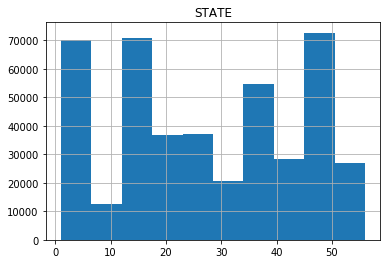

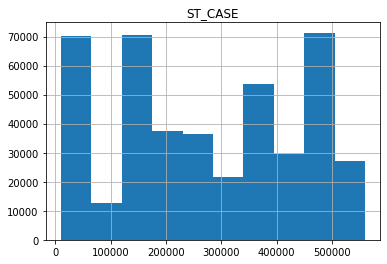

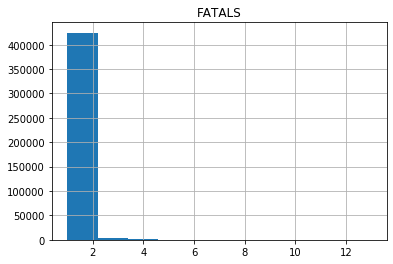

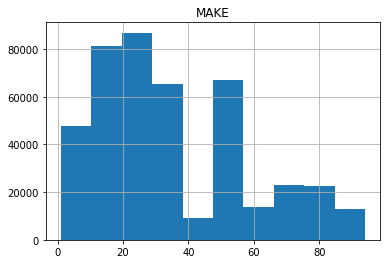

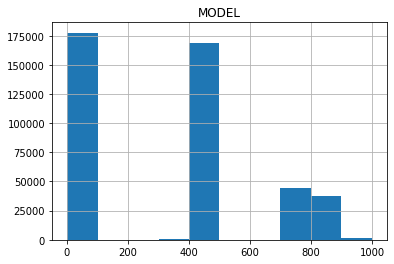

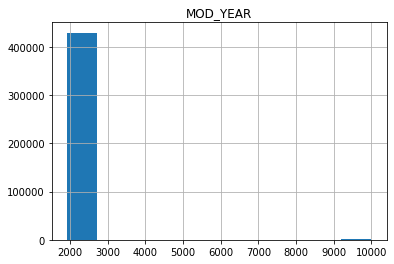

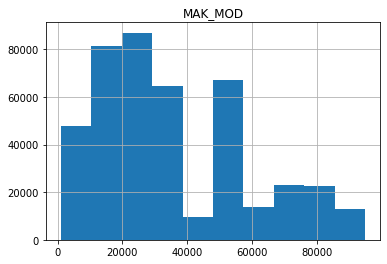

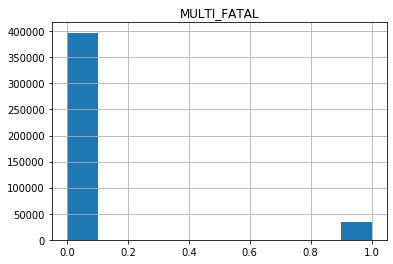

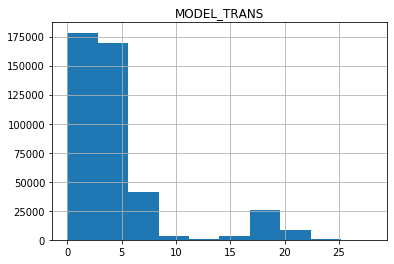

In [38]:
#Lets look at a historgram of each
import matplotlib.pyplot as plt
%matplotlib inline
for col in df_merge:
    df_merge.hist(column=col)

In [47]:
df_merge.astype({'STATE':'str', 'ST_CASE':'str', 'MAKE':'str', 'MODEL':'str'}).dtypes

STATE           object
ST_CASE         object
FATALS           int64
MAKE            object
MODEL           object
MOD_YEAR         int64
MAK_MOD          int64
MULTI_FATAL      int64
MODEL_TRANS    float64
dtype: object

In [48]:
df_merge_1fatal = df_merge.loc[df_merge['MULTI_FATAL'] == False]
print(len(df_merge_1fatal))
df_merge_Nfatal = df_merge.loc[df_merge['MULTI_FATAL'] == True]
print(len(df_merge_Nfatal))

df_merge_1fatal_sample = df_merge_1fatal.sample(n=len(df_merge_Nfatal), replace=False)
print(len(df_merge_1fatal_sample))

397111
33419
33419


In [49]:
df_merge_1fatal_sample_rebrand = df_merge_1fatal_sample.copy()
df_merge_1fatal_sample_rebrand['MULTI_FATAL'] = False

df_merge_Nfatal_rebrand = df_merge_Nfatal.copy()
df_merge_Nfatal_rebrand['MULTI_FATAL'] = True

frames = [df_merge_Nfatal_rebrand, df_merge_1fatal_sample_rebrand]

df_merge_concat = pd.concat(frames).sample(frac=1)
print(df_merge_concat.head())
print(len(df_merge_concat))

        STATE  ST_CASE  FATALS  MAKE  MODEL  MOD_YEAR  MAK_MOD  MULTI_FATAL  \
71299       6    61917       3    30     40      1997    30040         True   
272145     42   420178       1    12     23      2007    12023        False   
369444      8    80136       3    37     32      2012    37032         True   
143910     34   340244       2    12     23      2009    12023         True   
187256     22   220611       1    20    498      1977    20498        False   

        MODEL_TRANS  
71299           0.0  
272145          0.0  
369444          0.0  
143910          0.0  
187256          4.0  
66838


In [ ]:
## Address the 9999 unknown values

In [10]:
# - https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
# Try and use an SVM# Import train_test_split function
from sklearn.model_selection import train_test_split

X=df_merge_concat[['MAKE', 'MODEL', 'MOD_YEAR']]  # Features
y=df_merge_concat['MULTI_FATAL']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')

#Train the model using the training sets y_pred=clf.predict(X_test)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

[[4825 5471]
 [4468 5634]]
              precision    recall  f1-score   support

       False       0.52      0.47      0.49     10296
        True       0.51      0.56      0.53     10102

    accuracy                           0.51     20398
   macro avg       0.51      0.51      0.51     20398
weighted avg       0.51      0.51      0.51     20398

Accuracy: 0.5127463476811452


In [45]:
###    Today: Work on SVM
###    Change year to num again ---------
###    Deal with 9999 unknowns

In [24]:
# - https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
# Try and use an SVM# Import train_test_split function
from sklearn.model_selection import train_test_split

X=df_merge_concat[['MAKE', 'MODEL', 'MOD_YEAR']]  # Features
y=df_merge_concat['MULTI_FATAL']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) # 80% training and 20% test

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')

#Train the model using the training sets y_pred=clf.predict(X_test)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

[[25436    13]
 [ 8541     6]]
              precision    recall  f1-score   support

       False       0.75      1.00      0.86     25449
        True       0.32      0.00      0.00      8547

    accuracy                           0.75     33996
   macro avg       0.53      0.50      0.43     33996
weighted avg       0.64      0.75      0.64     33996

Accuracy: 0.7483821626073656


In [1]:
# https://stackabuse.com/scikit-learn-save-and-restore-models/
# https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

In [50]:
# What happens if we don't recode make and model as strings? This is a litmus test for recoding categoricals
from sklearn.model_selection import train_test_split

X=df_merge_concat[['MAKE', 'MODEL_TRANS', 'MOD_YEAR']]  # Features
y=df_merge_concat['MULTI_FATAL']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=2.0)
# from sklearn.svm import LinearSVC
# svclassifier = LinearSVC()


#Train the model using the training sets y_pred=clf.predict(X_test)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

[[4481 5519]
 [4594 5458]]
              precision    recall  f1-score   support

       False       0.49      0.45      0.47     10000
        True       0.50      0.54      0.52     10052

    accuracy                           0.50     20052
   macro avg       0.50      0.50      0.49     20052
weighted avg       0.50      0.50      0.49     20052

Accuracy: 0.49566128067025733


In [21]:
# Attempting to use OneHotEncoder
# https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
from sklearn.model_selection import train_test_split

X=df_merge_concat[['MAKE', 'MOD_YEAR']]  # Features
y=df_merge_concat['MULTI_FATAL']  # Labels

# Make and encode our make and model data
#   Once the data is completely translated with models we gotta do an ordinalEncoder to rebrand it
# from sklearn.preprocessing import OneHotEncoder
# makeEnc = OneHotEncoder()
# makeEnc.fit(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')

#Train the model using the training sets y_pred=clf.predict(X_test)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

[[5038 5197]
 [5283 4880]]
              precision    recall  f1-score   support

       False       0.49      0.49      0.49     10235
        True       0.48      0.48      0.48     10163

    accuracy                           0.49     20398
   macro avg       0.49      0.49      0.49     20398
weighted avg       0.49      0.49      0.49     20398

Accuracy: 0.48622413962153155


In [ ]:
make_numbers = {
    1:"American Motors",
    2:"Jeep/Kaiser-Jeep/Willys Jeep",
    3:"AM General",
    6:"Chrysler",
    7:"Dodge",
    8:"Imperial",
    9:"Plymouth",
    10:"Eagle",
    12:"Ford",
    13:"Lincoln",
    14:"Mercury",
    18:"Buick/Opel",
    19:"Cadillac",
    20:"Chevrolet",
    21:"Oldsmobile",
    22:"Pontiac",
    23:"GMC",
    24:"Saturn",
    25:"Grumman",
    26:"Coda",
    29:"Other Domestic",
    30:"Volkswagon",
    31:"Alfa Romeo",
    32:"Audi",
    33:"Austin/Austin-Healey",
    34:"BMW",
    35:"Datsun/Nissan",
    36:"Fiat",
    37:"Honda",
    38:"Isuzu",
    39:"Jaguar",
    40:"Lancia",
    41:"Mazda",
    42:"Mercedes-Benz",
    43:"MG",
    44:"Peugeot",
    45:"Porsche",
    46:"Renault",
    47:"Saab",
    48:"Subaru",
    49:"Toyota",
    50:"Triumph",
    51:"Volvo",
    52:"Mitsubishi",
    53:"Suzuki",
    54:"Acura",
    55:"Hyundai",
    56:"Merkur",
    57:"Yugo",
    58:"Infiniti",
    59:"Lexus",
    60:"Daihatsu",
    62:"Land Rover",
    63:"Kia",
    64:"Daewoo",
    65:"Smart",
    66:"Mahindra",
    67:"Scion",
    69:"Other Imports",
    70:"BSA",
    71:"Ducati",
    72:"Harley-Davidson",
    73:"Kawasaki",
    74:"Moto Guzzi",
    75:"Norton",
    76:"Yamaha",
    77:"Victory",
    78:"Other Make Moped",
    79:"Other Make Motored Cycle",
    80:"Brockway",
    81:"Diamond Reo/Reo",
    82:"Freightliner",
    83:"FWD",
    84:"International Harvester/Navistar",
    85:"Kenworth",
    86:"Mack",
    87:"Peterbilt",
    88:"Iveco/Magirus",
    89:"White/Autocar, White/GMC",
    90:"Bluebird",
    91:"Eagle Coach",
    92:"Gillig",
    93:"MCI",
    94:"Thomas Built",
    97:"Not Reported",
    98:"Other Make",
    99:"Unknown"
}

#print(sorted(df_merge["MAKE"].unique()))
make_list = []
make_dict = {}
make_list.append("<datalist>")
for make in sorted(df_merge["MAKE"].unique()):
    make_list.append('<option value ="' + str(make_numbers[make]) + '">')
    make_dict[make] = ""
make_list.append("</datalist>")
# print(make_list)
print("\n".join(make_list))
print(make_dict)

In [57]:
#print(sorted(df_merge["MAKE"].unique()))
model_list = []
model_dict = {}
model_list.append("<datalist>")
for model in sorted(df_merge["MODEL_TRANS"].unique()):
    model_list.append('<option value ="' + str(model) + '">')
    model_dict[model] = ""
model_list.append("</datalist>")
# print(make_list)
print("\n".join(model_list))
print(model_dict)

<datalist>
<option value ="All-Terrain Vehicles">
<option value ="Automobiles">
<option value ="Buses">
<option value ="Light Trucks">
<option value ="Med/Heavy Pickup">
<option value ="Med/Heavy Trucks - CBE">
<option value ="Med/Heavy Trucks - COE">
<option value ="Med/Heavy Trucks - COE (entry position unknown)">
<option value ="Med/Heavy Trucks - COE (high entry)">
<option value ="Med/Heavy Trucks - COE (low entry)">
<option value ="Med/Heavy Trucks - Unknown engine location">
<option value ="Med/Heavy Van-Based Vehicle">
<option value ="Motorcycles">
<option value ="Other (Bus)">
<option value ="Other (Light Trucks)">
<option value ="Other (Med/Heavy Trucks)">
<option value ="Other (Vehicle)">
<option value ="Other Make (Med/Heavy Trucks)">
<option value ="Other(Autos)">
<option value ="Unknown (Autos)">
<option value ="Unknown (Bus)">
<option value ="Unknown (LT)">
<option value ="Unknown cc (ATV)Unkown (motored cycle)">
<option value ="Unknown cc (Motorcycles)">
</datalist>
{'Al

In [ ]:
print("[")
for i in range(30):
    print(str(i) + ",")
print("]")